# Importación de librerias

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy

# Dataset

In [2]:
def cargar_dataset():
    """
    Carga el dataset contenido en un fichero .h5
    
    Devuelve:
    - train_set_x_orig (numpy.ndarray): Conjunto de entrenamiento X
    - train_set_y_orig (numpy.ndarray): Conjunto de entrenamiento Y
    - test_set_x_orig (numpy.ndarray): Conjunto de test X
    - test_set_y_orig (numpy.ndarray): Conjunto de test Y
    - classes (numpy.ndarray) = Conjunto de clases
    """
    
    train_dataset = h5py.File('dataset/train_happy.h5', 'r')
    train_set_x_orig = np.array(train_dataset['train_set_x'][:])
    train_set_y_orig = np.array(train_dataset['train_set_y'][:])
    classes = np.array(train_dataset['list_classes'][:])
    
    test_dataset = h5py.File('dataset/test_happy.h5', 'r')
    test_set_x_orig = np.array(test_dataset['test_set_x'][:])
    test_set_y_orig = np.array(test_dataset['test_set_y'][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1,-1))
    test_set_y_orig = test_set_y_orig.reshape((1, -1))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = cargar_dataset()

In [4]:
def dimensiones():
    """
    Imprime información relativa al dataset cargado anteriormente
    """
    
    num_ejemplos_train = train_set_x_orig.shape[0]
    num_ejemplos_test = test_set_x_orig.shape[0]
    ancho = train_set_x_orig.shape[1]
    alto = train_set_x_orig.shape[2]
    num_clases = len(classes)
    
    print(f'Número de ejemplos de entrenamiento: {num_ejemplos_train}')
    print(f'Número de ejemplos de test: {num_ejemplos_test}')
    print(f'Dimensión de las fotos: {ancho}x{alto}')
    print(f'Forma dataset X entrenamiento: {train_set_x_orig.shape}')
    print(f'Forma dataset Y entrenamiento: {train_set_y.shape}')
    print(f'Forma dataset X test: {test_set_x_orig.shape}')
    print(f'Forma dataset Y test: {test_set_y.shape}')
    print(f'Número de clases: {num_clases}')
    

In [5]:
dimensiones()

Número de ejemplos de entrenamiento: 600
Número de ejemplos de test: 150
Dimensión de las fotos: 64x64
Forma dataset X entrenamiento: (600, 64, 64, 3)
Forma dataset Y entrenamiento: (1, 600)
Forma dataset X test: (150, 64, 64, 3)
Forma dataset Y test: (1, 150)
Número de clases: 2


La imagen 80 tiene valor: 1


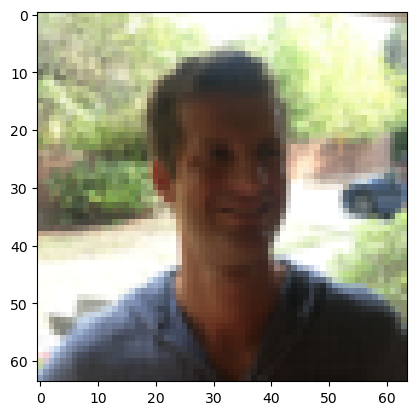

In [6]:
num = 80
plt.imshow(train_set_x_orig[num])
print(f"La imagen {num} tiene valor: {train_set_y[0, num]}")

# Algoritmo (desde 0)

Convertimos las imagenes en vectores:
(px ancho, px alto, 3) -> (px ancho * px alto * 3, 1).

Cada columna del dataset representa una imagen.

In [7]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print(f"train_set_x_flatten: {train_set_x_flatten.shape}")
print(f"test_set_x_flatten: {test_set_x_flatten.shape}")
print(f"train_set_y: {train_set_y.shape}")
print(f"test_set_y: {test_set_y.shape}")

train_set_x_flatten: (12288, 600)
test_set_x_flatten: (12288, 150)
train_set_y: (1, 600)
test_set_y: (1, 150)


Normalizamos el dataset para que el algoritmo funcione más rápido

In [8]:
train_set_x = train_set_x_flatten /255.
test_set_x = test_set_x_flatten / 255.

## Funciones

$sigmoid(z) = \frac{1}{1 + e^{-z}}$ donde $z = w^T x + b $

In [9]:
def sigmoid(z):
    """
    Calcula la función sigmoide de z
    
    Args:
    - z: Escalar o array de numpy
    
    Devuelve:
    - s: Función sigmoide de z
    """
    
    s = 1/(1+np.exp(-z))
    return s

La función de coste utilizada será:

$$J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$$

El objetivo es minimizarla. Para ello, debemos calcular las w y b que hagan mínima la función de coste. Para encontrar dichas variables, se utilizará **descenso de gradiente**. Las derivadas parciales de J respecto de w y b son las siguientes:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})$$

In [10]:
def forward_propagation(w, b, X, Y):
    """
    Devuelve el coste y las derivadas parciales de J respecto de w y b
    
    Args:
    - w (numpy.ndarray): Vector de pesos (num_px*num_px*3, 1)
    - b (int): Bias
    - X (numpy.ndarray): Conjunto de datos (num_px*num_px*3, num_ejemplos)
    - Y (numpy.ndarray): Vector de resultados (1, num_ejemplos) -> 0 si la cara no tiene una sonrisa, 1 si la tiene 
    
    Devuelve:
    - grads (dict): Diccionario con la derivada parcial de J respecto de w ['dw'] y respecto de b ['db']
    - cost (float): Valor de la función coste para los parámetros de la función
    """
    
    m = X.shape[1]  #Número de ejemplos
    
    A = sigmoid(np.dot(w.T, X) + b)   #Resultado de la función sigmoide
    cost = -1/m * np.sum(np.dot(Y,np.log(A).T) + np.dot((1-Y),np.log(1-A).T))
    dw = 1/m * np.dot(X, (A-Y).T)     #Derivada parcial de J respecto de w
    db = 1/m * np.sum(A-Y)            #Derivada parcial de J respecto de b
    
    grads = {"dw":dw, "db":db}
    
    return grads, cost

In [11]:
def gradient_descent (w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    """
    Optimiza w y b a través del algoritmo del descenso de gradiente
    
    Args:
    - w (numpy.ndarray): Vector de pesos (num_px*num_px*3, 1)
    - b (int): Bias
    - X (numpy.ndarray): Conjunto de datos (num_px*num_px*3, num_ejemplos)
    - Y (numpy.ndarray): Vector de resultados (1, num_ejemplos) -> 0 si la cara no tiene una sonrisa, 1 si la tiene 
    - num_iterations (int): Numero de iteraciones del bucle de optimización
    - learning_rate (float): Tasa de aprendizaje para la actualización de pesos y bias
    - print_cost (boolean): True para imprimir el coste cada 100 pasos
    
    Devuelve:
    - params (dict): Diccionario con el valor final de w ['w'] y b ['b']
    - costs (list): Lista de costes cada 100 pasos
    """
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(1, num_iterations+1):
        grads, cost = forward_propagation(w, b, X, Y)
        
        dw = grads['dw']
        db = grads['db']
        
        w = w - learning_rate*dw
        b = b - learning_rate*db
        
        if i%100==0 or i==1:
            costs.append(cost)
            if print_cost:
                print(f"Coste en la iteración {i}: {cost}")
        
    params = {"w": w, "b":b}
    
    return params, costs

In [12]:
def predict(w, b, X):
    """
    Predice 0 o 1
    
    Args:
    - w (numpy.ndarray): Vector de pesos (num_px*num_px*3, 1)
    - b (int): Bias
    - X (numpy.ndarray): Conjunto de datos (num_px*num_px*3, num_ejemplos)
    
    Devuelve:
    - Y_prediction (numpy.ndarray): Vector con las aproximaciones 0 o 1 (1, num_ejemplos)
    """
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if(A[0,i]>0.5):
            Y_prediction[0,i] = 1
    
    return Y_prediction

In [13]:
def model(X_train, Y_train, X_test, Y_test, num_iterations, learning_rate=0.5, print_cost=False):
    '''
    Función que engloba todo el modelo de regresión logística
    
    Args:
    - X_train (numpy.ndarray): Conjunto de datos de entrenamiento (num_px*num_px*3, num_ejemplos)
    - Y_train (numpy.ndarray): Vector de resultados de entrenamiento (1, num_ejemplos) 
    - X_test (numpy.ndarray): Conjunto de datos de test (num_px*num_px*3, num_ejemplos)
    - Y_test (numpy.ndarray): Vector de resultados de test (1, num_ejemplos) 
    - num_iterations (int): Número de iteraciones del bucle de optimización
    - learning_rate (float): Tasa de aprendizaje para la actualización de pesos y bias
    - print_cost (boolean): True para imprimir el coste cada 100 pasos y la precisión del modelo para el entrenamiento y test
    
    Devuelve:
    - d (dict): Diccionario que contiene la lista de costes ["costs"], predicción en los ejemplos de test ["Y_prediction_test"],
                predicción en los ejemplos de entrenamiento ["Y_prediction_train"], precisión en entrenamiento ["score_train"],
                precisión en test ["score_test"], vector de pesos ["w"], bias ["b"]
    '''
    
    
    w = np.zeros((X_train.shape[0], 1))
    b = 0.
    
    params, costs = gradient_descent(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = params['w']
    b = params['b']
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    score_train = 100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100
    score_test = 100 - np.mean(np.abs(Y_prediction_test - Y_test))* 100
    
    if print_cost:
        print(f'Precisión en entrenamiento: {score_train}%')
        print(f'Precisión en test: {score_test}%')
        
    d = {"costs": costs,
         "Y_prediction_train" : Y_prediction_train,
         "Y_prediction_test": Y_prediction_test, 
         "score_train": score_train,
         "score_test": score_test,
         "w" : w, 
         "b" : b}
    
    return d

## Pruebas del algoritmo

In [14]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Coste en la iteración 1: 0.6931471805599453
Coste en la iteración 100: 2.016452672651478
Coste en la iteración 200: 0.9400012027717219
Coste en la iteración 300: 0.5109581003071446
Coste en la iteración 400: 0.21272586466206095
Coste en la iteración 500: 0.18113062079703315
Coste en la iteración 600: 0.16894042351679134
Coste en la iteración 700: 0.15957595593644006
Coste en la iteración 800: 0.15176417365385994
Coste en la iteración 900: 0.14500726814765197
Coste en la iteración 1000: 0.13905151113379366
Coste en la iteración 1100: 0.1337392995563977
Coste en la iteración 1200: 0.1289598785605152
Coste en la iteración 1300: 0.12462974963835095
Coste en la iteración 1400: 0.12068338225885512
Coste en la iteración 1500: 0.1170680633538238
Coste en la iteración 1600: 0.11374067468980462
Coste en la iteración 1700: 0.11066550189543328
Coste en la iteración 1800: 0.10781266217244054
Coste en la iteración 1900: 0.10515693551713456
Coste en la iteración 2000: 0.10267687478633207
Precisión en

## Gráfico sobre el rendimiento con diferentes tasas de aprendizaje

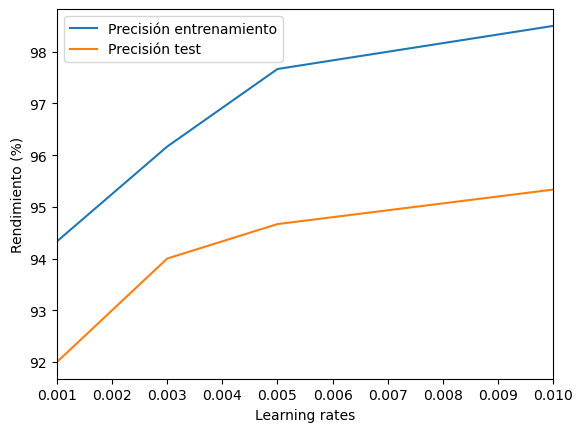

In [15]:
learning_rates = [0.001, 0.003, 0.005, 0.01]
scores_train = []
scores_test = []

for alpha in learning_rates:
    logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=alpha, print_cost=False)        
    scores_train.append(logistic_regression_model['score_train'])
    scores_test.append(logistic_regression_model['score_test'])
    
plt.plot(learning_rates, scores_train, label="Precisión entrenamiento")
plt.plot(learning_rates, scores_test, label="Precisión test")
plt.xlim(learning_rates[0], learning_rates[-1])
plt.xlabel('Learning rates')
plt.ylabel('Rendimiento (%)')
plt.legend()
plt.show()

Según la gráfica, de las tasas de aprendizajes tomadas, la que mejor rendimiento da es 0.01

# Algoritmo (con sklearn)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [17]:
norm = StandardScaler()
X_train = train_set_x_flatten.T
X_train_norm = norm.fit_transform(X_train)

In [18]:
model = LogisticRegression(max_iter=1500)

y_train = train_set_y.reshape(-1)
model.fit(X_train_norm, y_train)

LogisticRegression(max_iter=1500)

In [19]:
X_test = test_set_x_flatten.T
X_test_norm = norm.fit_transform(X_test)
y_test = test_set_y.reshape(-1)

print(f'El modelo tiene una precisión del {model.score(X_train_norm, y_train) * 100}% en los datos de entrenamiento ')
print(f'El modelo tiene una precisión del {(model.score(X_test_norm, y_test) * 100):.2f}% en los datos de test ')

El modelo tiene una precisión del 100.0% en los datos de entrenamiento 
El modelo tiene una precisión del 97.33% en los datos de test 
